# fft score cam implementation


### Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import wandb
import pickle
#from PIL import Image
import torch.nn.functional as F
from torch.utils.data import DataLoader
from skimage import transform
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import cv2
from plotting_utils import RF_Visualizer



### Class and Function Definitions

In [2]:

def test_in_distribution(model, dataset):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    slice_accs = []
    example_majority_accs = []
    example_sum_accs = []
    for i, (trans, label) in enumerate(dataloader):
        # print(i, len(dataset))
        trans, label = trans[0].cuda(), label[0].cuda()
        with torch.no_grad():
            pred = model(trans)
            pred_class = torch.argmax(pred, dim=-1)
        accuracy = torch.mean((pred_class == label).float()).cpu().numpy()
        majority_accuracy = (torch.mode(pred_class)[0] == label).float().cpu().numpy()
        sum_accuracy = (torch.argmax(torch.sum(pred, dim=0)) == label).float().cpu().numpy()
        slice_accs.append(accuracy)
        example_majority_accs.append(majority_accuracy)
        example_sum_accs.append(sum_accuracy)
    return np.mean(np.asarray(slice_accs)), np.mean(np.asarray(example_majority_accs)), np.mean(
        np.asarray(example_sum_accs))


class CamExtractor():
    """
        Extracts cam features from the model, this one is for AlexNet1D. May need to be tweaked for other models
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.feature_extractor._modules.items():
            x = module(x)  # Forward
            #print(x)
            if int(module_pos) == self.target_layer:
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.fc3(F.relu(self.model.fc2(F.relu(self.model.fc1(x)))))
        # x = self.model.classifier(x)
        return conv_output, x


class SCORECAM_1dcnn():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.model.eval() #set dropout and batch norm layers to evaluation mode before running inferance
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_slice, target_class=None):
        # Score-CAM
        ## The implementation was derived from https://github.com/tabayashi0117/Score-CAM and modified under MIT license

        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model 
        #extractor = CamExtractor(model, target_layer)
        conv_output, model_output = self.extractor.forward_pass(input_slice)
        if target_class is None:
            target_class = np.argmax(F.softmax(model_output).data.numpy())
        # Get convolution outputs
        target = conv_output[0]
        target = F.relu(target)
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        #print(len(target))
        test_var_weights = []
        for i in range(len(target)): #iterate over each activation map
            # Unsqueeze
            saliency_map = torch.unsqueeze(torch.unsqueeze(target[i,:],0),0)
            #print("salmap",saliency_map.shape)
            # Upsampling to input size, from output feature size of 4 to 256 in this case
            saliency_map = F.interpolate(saliency_map, size=(256), mode='linear', align_corners=False)
            if saliency_map.max() == saliency_map.min():
                continue
            # Scale between 0-1
            norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
            #print(norm_saliency_map)
            # Get the target score
            X_Hl =input_slice*norm_saliency_map
            activation_map_score = self.extractor.forward_pass(X_Hl)[1]
            w = F.softmax(activation_map_score,dim=1)[0]
            w_class =w[target_class]
            test_var_weights.append(w_class)
            #print("w_class",w_class)
            cam += w_class.data.numpy() * target[i, :].data.numpy() #experimenting with implementation
            #cam += w_class.data.numpy() * saliency_map.data.numpy()

            #print("cam",cam)
        cam_final = transform.resize(cam, (256,))
        cam_final = np.maximum(cam_final, 0)
        # print("target",target)
        # print("cam2",cam_final)
        # if np.min(cam_final) != np.max(cam_final):
        #     cam_final = (cam_final - np.min(cam_final)) / (np.max(cam_final) - np.min(cam_final))  # Normalize between 0-1
        # else:
        #     cam_final = (cam_final - np.min(cam_final)) 
        
        return cam_final



### Load Data
Import data using whatever torch dataloader your original model utilized. 

In [3]:

if __name__ == "__main__":
    from model import AlexNet1D
    from dataset_oracle import InDistributionTestDataset, DataLoader,InDistributionTrainDataset
    from scipy.io import loadmat


    seqs = {}
    with open("/raid/backup_storage_oldDGX/ORACLE/mat_files/raw/train.pkl", "rb") as f:#Oracle
    #with open("/raid/backup_storage_oldDGX/LORA/Year_1_outdoor/outdoor_dataset_1/mat_files/raw/train.pkl", "rb") as f:
        file_dict = pickle.load(f)
    filenames = file_dict["files"]
    print(filenames)
    for i, name in enumerate(filenames):
        #print(i, len(filenames))
        seqs[name] = loadmat(name)["f_sig"][0]
    dataset = InDistributionTestDataset(seqs,"val")
    #dataset = InDistributionTrainDataset(seqs)
    train_dataset = InDistributionTrainDataset(seqs)
    del seqs


['/raid/backup_storage_oldDGX/ORACLE/mat_files/raw/WiFi_air_X310_3123D76_8ft_run1', '/raid/backup_storage_oldDGX/ORACLE/mat_files/raw/WiFi_air_X310_3123D79_62ft_run1', '/raid/backup_storage_oldDGX/ORACLE/mat_files/raw/WiFi_air_X310_3123D54_44ft_run1', '/raid/backup_storage_oldDGX/ORACLE/mat_files/raw/WiFi_air_X310_3123D70_14ft_run2', '/raid/backup_storage_oldDGX/ORACLE/mat_files/raw/WiFi_air_X310_3123D65_26ft_run2', '/raid/backup_storage_oldDGX/ORACLE/mat_files/raw/WiFi_air_X310_3123D7E_26ft_run2', '/raid/backup_storage_oldDGX/ORACLE/mat_files/raw/WiFi_air_X310_3123D65_8ft_run1', '/raid/backup_storage_oldDGX/ORACLE/mat_files/raw/WiFi_air_X310_3123D76_38ft_run2', '/raid/backup_storage_oldDGX/ORACLE/mat_files/raw/WiFi_air_X310_3123D54_50ft_run1', '/raid/backup_storage_oldDGX/ORACLE/mat_files/raw/WiFi_air_X310_3123D79_38ft_run1', '/raid/backup_storage_oldDGX/ORACLE/mat_files/raw/WiFi_air_X310_3123D76_32ft_run2', '/raid/backup_storage_oldDGX/ORACLE/mat_files/raw/WiFi_air_X310_3123D70_50ft_

### Load model


In [4]:

#experiment 
#model=torch.load("model/ORACLE_Original_4.weights").cpu()

model = AlexNet1D(train_dataset.num_classes)#.cuda()
model.load_state_dict(torch.load("model/ORACLE_Original_state_dict2_0.weights"))#Oracle
#model.eval() #set dropout and batch norm layers to evaluation mode before running inferance
#model=torch.load("model/Lora_Dev1_500kCFO_5ID_6.weights").cpu()
print(model)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


#parameters for test
#input_image = resized_slice
target_class = 0 #emitter 0 of 6
target_layer = 22
sample_test_idx= 52#52 might be a sync
sample_rate = 5e6

for i, (trans, label) in enumerate(dataloader):#hardcoded change
    #trans, label = trans[0].cuda(), label[0].cuda()
    if i == sample_test_idx:
        trans, label = trans[0], label[0]
        # slice_of_trans = trans[0,:,:]
        # # slice_of_trans[0,0:30] = torch.Tensor([np.random.randn(30)/2])
        # # slice_of_trans[1,0:30] = torch.Tensor([np.random.randn(30)/2])
        # input_slice=slice_of_trans.expand(1,-1,-1)
        #pred = F.softmax(model(input_slice))
        #print(pred)
        #pred_class = torch.argmax(pred, dim=-1)

        rf_visualizer = RF_Visualizer(trans,label,sample_rate)

        break


AlexNet1D(
  (feature_extractor): ModuleList(
    (0): Conv1d(2, 128, kernel_size=(7,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=same)
    (6): ReLU()
    (7): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
    (8): ReLU()
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=same)
    (11): ReLU()
    (12): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=same)
    (16): ReLU()
    (17): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
    (18): ReLU()

### Spot Check Data

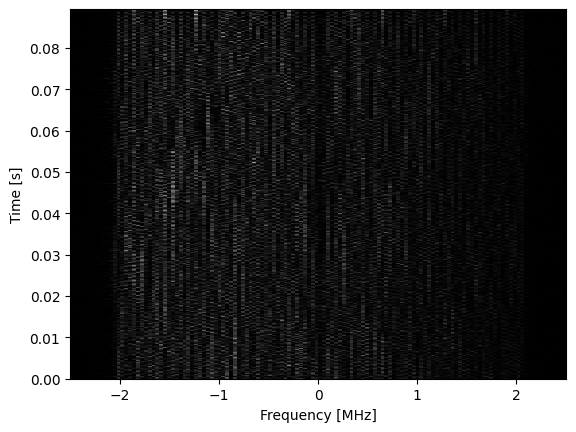

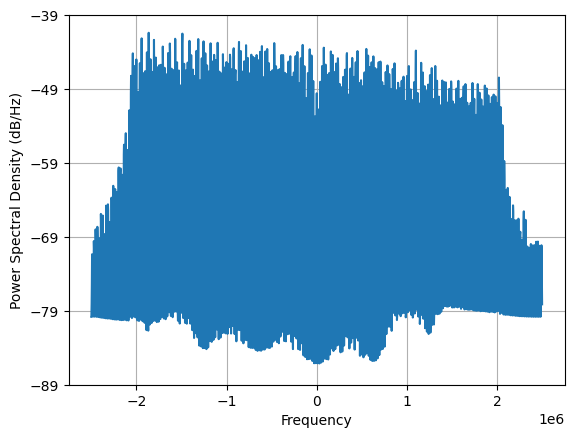

In [5]:

#check data
rf_visualizer.plotSpectrogram(fftWindow='rectangular', fftSize=128, winLen = 128,overlap=127)
#rf_visualizer.plotSpectrogramArlpy(fftSize=2048,cLim=30)
rf_visualizer.plotPSD(fftWindow='blackman', fftSize=2048)


### Create Class Activation Maps

(12800,)
[13.37230301 12.98682976 12.60135651 ...  9.13269234  9.84930325
 10.56591415]
[[13.37230301 13.37230301 13.37230301 ... 13.37230301 13.37230301
  13.37230301]
 [12.98682976 12.98682976 12.98682976 ... 12.98682976 12.98682976
  12.98682976]
 [12.60135651 12.60135651 12.60135651 ... 12.60135651 12.60135651
  12.60135651]
 ...
 [ 9.13269234  9.13269234  9.13269234 ...  9.13269234  9.13269234
   9.13269234]
 [ 9.84930325  9.84930325  9.84930325 ...  9.84930325  9.84930325
   9.84930325]
 [10.56591415 10.56591415 10.56591415 ... 10.56591415 10.56591415
  10.56591415]]
about to superimpose (12800, 256, 3) (12800, 256, 3)


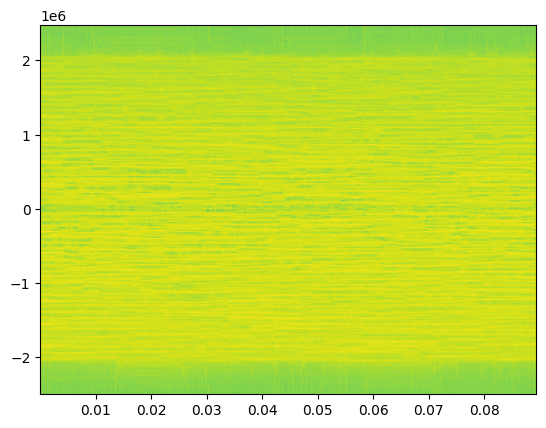

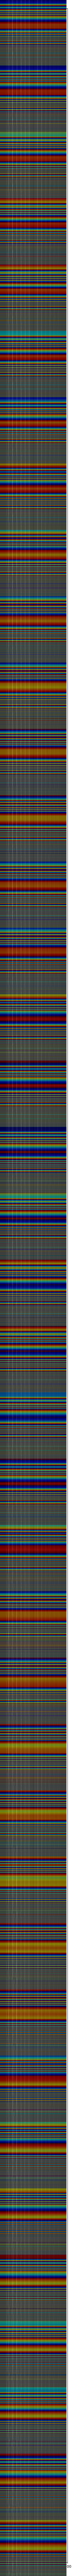

In [9]:


cam_class = SCORECAM_1dcnn(model, target_layer)

#Create cam of single slice from trans example.
slice_of_trans = trans[37,:,:]#grab slice 0,Note 37 for debugging bad, 27 for good
# slice_of_trans[0,120:150] = torch.Tensor([np.random.randn(30)/8])
# slice_of_trans[1,120:150] = torch.Tensor([np.random.randn(30)/8])
input_slice=slice_of_trans.expand(1,-1,-1)
#cam_output = cam_class.generate_cam(input_slice, target_class)


#generate maps for all slices in example
#Idea TODO:Create slice generator which allows arbitrary overlap inside of example trans
all_cams_in_trans = np.array([])
for i in range(0,50):#range(0,len(trans)):
    slice_of_trans = trans[i,:,:]
    input_slice=slice_of_trans.expand(1,-1,-1)
    cam_output = cam_class.generate_cam(input_slice, target_class)
    all_cams_in_trans=np.append(all_cams_in_trans,cam_output)
print(all_cams_in_trans.shape)


title='test'
#rf_visualizer.plot_spec_with_time_cam_heatmap(all_cams_in_trans, title, fftWindow='rectangular', fftSize=256)

Fs = sample_rate
data = rf_visualizer.trans_full_arr
fftWindow='rectangular'
fftSize=256
cams_arr = all_cams_in_trans
#create spectrogram background from original data
winLen = fftSize
overlap = fftSize-1
if fftWindow == "rectangular":
    spectrum,freqs,t,im =plt.specgram(data, NFFT=fftSize, Fs=Fs, 
    window=lambda data: data*np.ones(winLen),  noverlap=overlap)
    transpose_spectrum = np.array(spectrum).T
    #print(len(data))
    #print(transpose_spectrum.shape)
    #plt.imshow(transpose_spectrum, aspect='auto', extent = [Fs/-2/1e6, Fs/2/1e6, 0, len(data)/Fs], interpolation = 'none',cmap ='gray')


#normalize cam for plotting
if np.min(cams_arr) != np.max(cams_arr):
    cam_final = (cams_arr - np.min(cams_arr)) / (np.max(cams_arr) - np.min(cams_arr))  # Normalize between 0-1
else:
    cam_final = (cams_arr - np.min(cams_arr)) 

# Reshape and normalize cam_arr to create cam_img
print(cams_arr)
cam_img = np.tile(cams_arr, (transpose_spectrum.shape[1], 1)).T  # Duplicate each row across W columns
print(cam_img)
cam_img = (cam_img * 255).astype(np.uint8)  # Convert to 8-bit format

#overlay heatmap on time axis according to cam
heatmap_img = cv2.applyColorMap(cam_img, cv2.COLORMAP_JET)

#prep section of spectrum corresponding to heatmap
transpose_spectrum_sliced = transpose_spectrum[0:len(heatmap_img),:]
transpose_spectrum_sliced = cv2.normalize(transpose_spectrum_sliced, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
transpose_spectrum_sliced = np.uint8(transpose_spectrum_sliced)
transpose_spectrum_sliced = cv2.cvtColor(transpose_spectrum_sliced, cv2.COLOR_GRAY2BGR)
transpose_spectrum_sliced = transpose_spectrum_sliced.astype(np.uint8)

print("about to superimpose",heatmap_img.shape,transpose_spectrum_sliced.shape)
super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, transpose_spectrum_sliced, 0.5, 0)

#show plot
# fig = plt.figure(figsize=(super_imposed_img.shape[1]/100, super_imposed_img.shape[0]/100))
# fig.figimage(super_imposed_img)
plt.imshow(super_imposed_img, aspect='auto', extent = [Fs/-2/1e6, Fs/2/1e6, 0, len(cams_arr)/Fs], interpolation = 'none')

plt.title(title)
# add_axes([xmin,ymin,dx,dy]) 
#axes = fig.add_axes([0.5, 1, 0.5, 1])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [s]")
plt.show()
# fig.title(title)
# # add_axes([xmin,ymin,dx,dy]) 
# axes = fig.add_axes([0.5, 1, 0.5, 1])
# fig.xlabel("Frequency [MHz]")
# fig.ylabel("Time [s]")
# fig.show()

# # Full forward pass
# # conv_output is the output of convolutions at specified layer
# # model_output is the final output of the model 
# extractor = CamExtractor(model, target_layer)
# conv_output, model_output = extractor.forward_pass(input_slice)
# if target_class is None:
#     target_class = np.argmax(model_output.data.numpy())
# # Get convolution outputs
# target = conv_output[0]
# target = F.relu(target) #experimenting with Relu to try to fix negative targets
# # Create empty numpy array for cam
# cam = np.ones(target.shape[1:], dtype=np.float32)
# # Multiply each weight with its conv output and then, sum
# #print(len(target))
# test_var_weights = []
# for i in range(len(target)): #iterate over each activation map
#     # Unsqueeze
#     saliency_map = torch.unsqueeze(torch.unsqueeze(target[i,:],0),0)

#     # Upsampling to input size, from output feature size of 4 to 256 in this case
#     saliency_map = F.interpolate(saliency_map, size=(256), mode='linear', align_corners=False)
    
#     #skip the filters which have no response to input
#     if saliency_map.max() == saliency_map.min():
#         print("SKIPPING Filter")
#         continue

#     # Scale between 0-1
#     norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
    
#     # Get the target score
#     X_Hl =input_slice*norm_saliency_map
#     activation_map_score = extractor.forward_pass(X_Hl)[1]
#     w = F.softmax(activation_map_score,dim=1)[0]
#     w_class =w[target_class]
#     test_var_weights.append(w_class)
#     print("w_class",w_class)
#     cam += w_class.data.numpy() * target[i, :].data.numpy() 

#     print("cam",cam)
#     print(w_class.data.numpy())
#     if w_class.data.numpy() > 0.90:
#         print("breaking loop for debug")
#         break
# cam_final = transform.resize(cam, (256,))
# cam_final = np.maximum(cam_final, 0)
# print("target",target)
# print("cam2",cam_final)
# if np.min(cam_final) != np.max(cam_final):
#     cam_output = (cam_final - np.min(cam_final)) / (np.max(cam_final) - np.min(cam_final))  # Normalize between 0-1
# else:
#     cam_output = (cam_final - np.min(cam_final)) 




# # #cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
# # # cam = np.uint8(Image.fromarray(cam).resize((input_slice.shape[2],
# # #                 input_slice.shape[3]), Image.ANTIALIAS))/255

# # # #flip and take only top 90% to view
# # # cam_90 = cam.squeeze().copy()
# # # q_90 = np.quantile(cam_90, 0.9)
# # # cam_90 = (cam_90>q_90).astype("int")



### Plot results

In [7]:

#plot
original_slice_input = input_slice.squeeze()
class_label =label[sample_test_idx].data.numpy()
pred = F.softmax(model(input_slice),dim=1)[0]
pred_acc_label = pred[target_class].data.numpy()

C = 0 #0=I, 1 =Q
channel_C_og_slice = original_slice_input[C,:].data.numpy()
#min_slice = np.min(channel_C_og_slice)
#original_slice_input_norm = (channel_C_og_slice - np.min(channel_C_og_slice)) / (np.max(channel_C_og_slice) - np.min(channel_C_og_slice))  # Normalize between 0-1
original_slice_input_norm = (channel_C_og_slice) / (np.max(channel_C_og_slice))  # Normalize between -1->1
title="True class label: "+str(class_label)+", Prediction probability of target "+str(target_class)+":"+str(pred_acc_label)+", Channel: "+str(C)
fig = go.Figure([
go.Scatter(x=np.arange(0,len(original_slice_input[-1]),1), y=original_slice_input_norm,
                mode='lines',
                name='Raw signal'),

go.Scatter(x=np.arange(0,len(original_slice_input[-1]),1),
                        y=cam_output.squeeze(),
                        marker=dict(size=4),
                mode='lines+markers',
                name='Raw CAM',
)])

fig.update_layout(
title=title,
font=dict(size=20),
width=1600,
height=700,
yaxis_range=[-1,1],
paper_bgcolor='rgba(0,0,0,0)',
plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()


